# Beware of the winner's curse

A statistically significant estimate is an over-estimate! Sounds odd, right?  Because an experiment generates an unbiased estimate of a treatment effect.  

I came across [this Medium post](https://medium.com/airbnb-engineering/selection-bias-in-online-experimentation-c3d67795cceb) that brought up a really interesting topic, selection bias in experiments that result from the sharp threshold that p-values introduce.  I've turned the topic into a simulation to demonstrate in code why and how this can arise.  

Why does this matter?  If you run several experiments and roll out new product features you may be interested to know the total impact of the set of new feature rollouts.  You might then think that you can simply add up the observed effect sizes from each of the experiments and, voila, you have the cumulative effect.  You reason that in each experiment you have an unbiased treatment effect, and since each experiment was run independently such that one experiment was completed and the new feature rolled out before the next experiment was started, adding the effect sizes together makes sense.  And it does, apart from the fact that you used a decision threshold to determine which experimental features to rollout.  Simply summing up the effect sizes of only statistically significant experiments will bias the estimated cumulative effect size.  

### Notebooks
[R](https://github.com/darrelrobinson/a2bofdatascience/blob/main/advanced%20analysis/The%20Winner's%20Curse.ipynb)

[Python](https://github.com/darrelrobinson/a2bofdatascience/blob/main/advanced%20analysis/The%20Winner's%20Curse%20-%20Python.ipynb)

## Set up

In [7]:
set.seed(145)
library(tidyverse)

We need to set some parameters for the simulation.  Let's simulate an experiment with a true effect size of 1 -- Group A will have a mean of 0, Group B a mean of 1.  The difference between A and B is our test statistic.  Given these values we'll do a power calculation to get a sample size that will find a statistically significant result 80% of the time.  

In [24]:
## get some parameters
effect_size=1
sd=10
powered_test = power.t.test(delta=effect_size, sd=sd, sig.level=0.05, power=0.8)
n = ceiling(powered_test$n)*2


## Simulate

Now we can write a small function to pull two samples, A and B, calculate the difference in means, and return the difference along with the p-value of the difference. 

In [8]:
sample_it = function(n, es, sd){
  a = rnorm(n/2, 0, sd)
  b = rnorm(n/2, 0+es, sd)
  t = t.test(a, b)
  diff = t$estimate[[2]] - t$estimate[[1]]
  p = t$p.value
  return(list(diff = diff, p = p))
}

I'll use the familiar replicate() function to simulate this experiment 100 times, and I'll use the standard p-value of 0.05 to denote statistical significance.  

In [10]:
## simulate
sim_data = data.frame(t(replicate(100, sample_it(n, effect_size, sd)))) %>% unnest(cols= c(diff, p))
sim_data = sim_data %>% mutate(significant=case_when(p<0.05 ~ 1,
                                          TRUE ~ 0))

And a quick sanity check, roughly 80% of the simulations should have a p-value less than 0.05:

In [11]:
## sanity check
sim_data %>%
  summarise(power=mean(significant))

power
<dbl>
0.79


## The Winner's Curse

Now, here's the interesting part.  Because we set the true effect size to 1, the true cumulative effect of all of the experiments that returned a statistically significant estimate should be equal to the number of statistically significant experiments, 79 in this case.  But, if we sum up the observed differences between A and B for all of the experiments for which we found a statistically significant difference, this sum will be larger than 79!

In [16]:
sim_data %>%
  filter(significant==1) %>%
  summarise(estimated_cum_effect=sum(diff),
            true_cum_effect=n()) %>%
  mutate(absolute_bias = estimated_cum_effect - true_cum_effect,
        relative_bias = (estimated_cum_effect - true_cum_effect) / true_cum_effect)

estimated_cum_effect,true_cum_effect,absolute_bias,relative_bias
<dbl>,<int>,<dbl>,<dbl>
89.44491,79,10.44491,0.1322141


And the more experiments you run, the larger in absolute magnitude the total bias will be:

In [26]:
sim_data_1000 = data.frame(
    t(
        replicate(1000, 
                  sample_it(n, 
                            effect_size, 
                            sd)
                 )
    )
) %>% 
  unnest(cols=c(diff, p)) %>%
  mutate(significant=case_when(p<0.05 ~ 1,
                              TRUE ~ 0))

sim_data_1000 %>%
  filter(significant==1) %>%
  summarise(estimated_cum_effect=sum(diff),
           true_cum_effect=n()) %>%
  mutate(absolute_bias = estimated_cum_effect - true_cum_effect,
        relative_bias = (estimated_cum_effect - true_cum_effect) / true_cum_effect)

estimated_cum_effect,true_cum_effect,absolute_bias,relative_bias
<dbl>,<int>,<dbl>,<dbl>
934.9835,827,107.9835,0.1305725


Why is that?  It can all be explained by going back to the concept of a sampling distribution.  If we look at the distribution of effect sizes from our simulation, we will see that it is centered about 1, and is roughly normally distributed.  Some of these estimates are statistically significant, whereas others are not.  

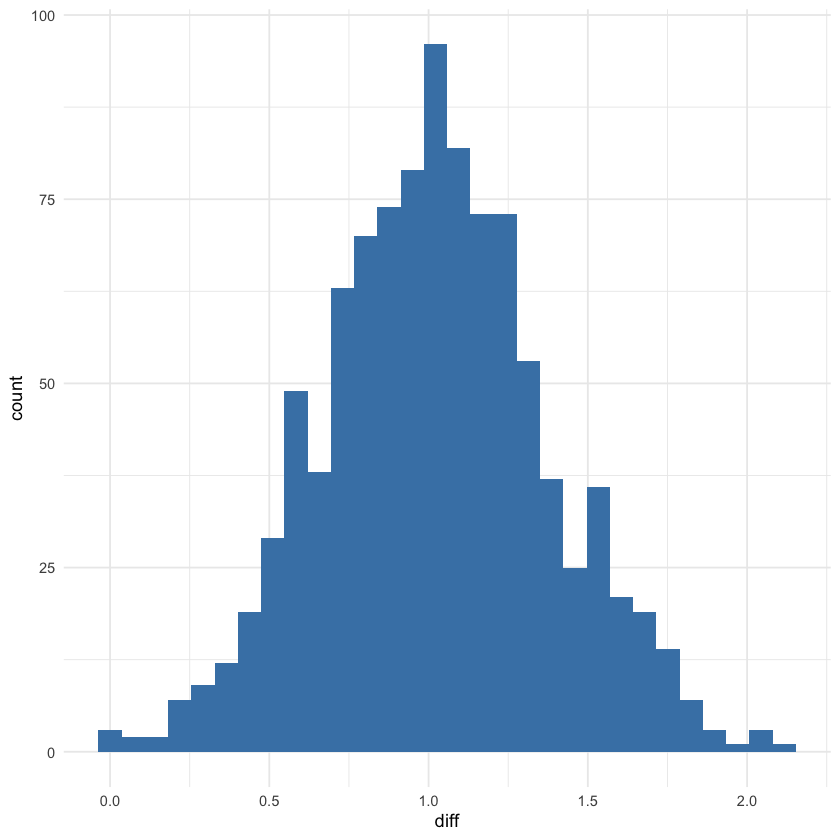

In [32]:
sim_data_1000 %>%
  ggplot(aes(x=diff)) + 
  geom_histogram(fill='steelblue', bins=30) + 
  theme_minimal()

But guess where all of the insignificant estimates are -- they are the smaller estimates!  And the statistically significant estimates are a subset of the larger estimates from full sampling distribution.  

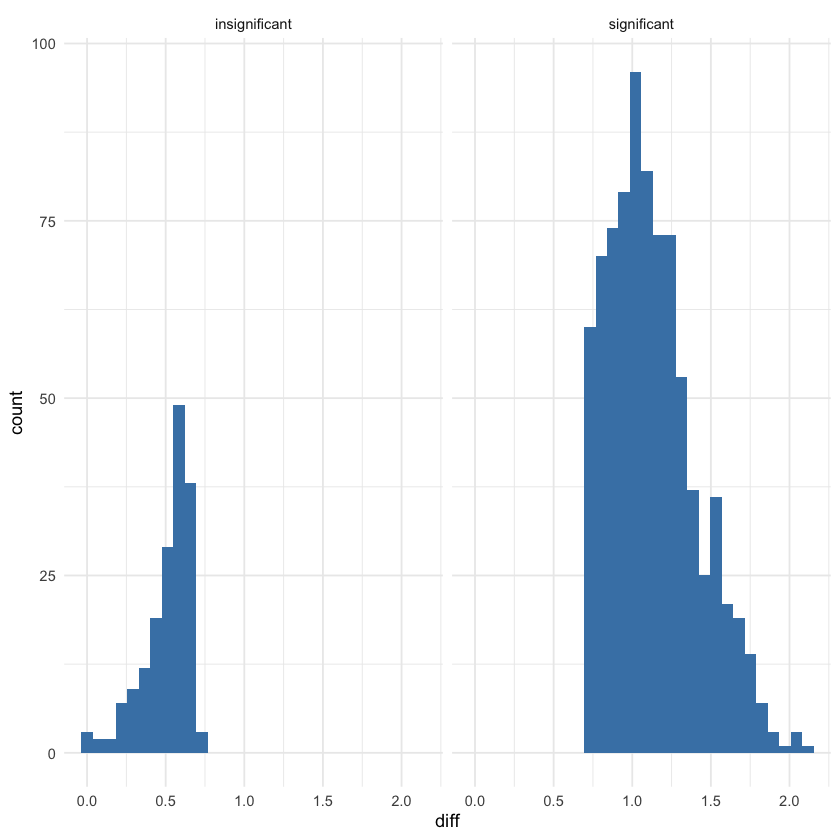

In [33]:
sim_data_1000 %>% 
  mutate(significant=ifelse(significant==1, 'significant', 'insignificant')) %>%
  ggplot(aes(x=diff)) + 
  geom_histogram(fill='steelblue', bins=30) + 
  facet_grid(~significant) +
  theme_minimal()

By using a power level of 0.8, what you do in effect is to ensure that you will find a statistically significant estimate for those **80% of experiments with the largest effect sizes**.  So you are truncating the true sampling distribution and selecting only the top 80%.  Naturally, by removing the smallest 20% of effect sizes, the mean of the truncated distribution no longer equals the true mean of the sampling distribution -- it is positively biased.  Thus, we have the winner's curse, *a statistically significant estimate is most likely an over-estimate of the true effect size*.  